<a href="https://colab.research.google.com/github/Ragav5108/Datascience_internship/blob/main/Imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. Import Libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# 2. Load Dataset
# Download: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
df = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")  # file name from Kaggle dataset

print("Dataset Shape:", df.shape)
print(df.head())

# Convert target to numeric
df["sentiment"] = df["sentiment"].map({"positive":1, "negative":0})

Dataset Shape: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [4]:
# 3. Clean Text
def clean_text(text):
    text = re.sub(r"<.*?>", "", text)     # remove HTML tags
    text = re.sub(r"http\S+", "", text)   # remove links
    text = re.sub(r"[^a-zA-Z\s]", "", text) # keep only letters
    return text.lower().strip()

df["clean_review"] = df["review"].apply(clean_text)

/tmp/ipython-input-1061483182.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment", data=df, palette="Set2")


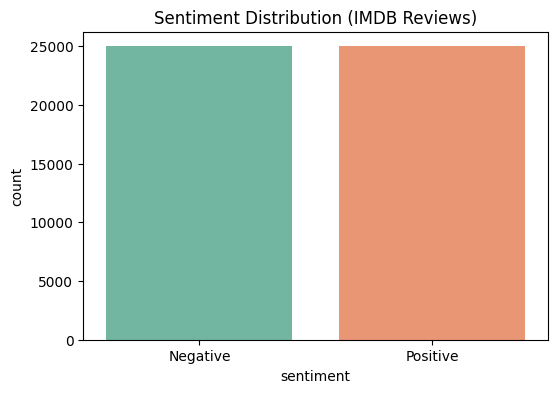

In [6]:
# Sentiment Count
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment", data=df, palette="Set2")
plt.xticks([0,1], ["Negative","Positive"])
plt.title("Sentiment Distribution (IMDB Reviews)")
plt.show()

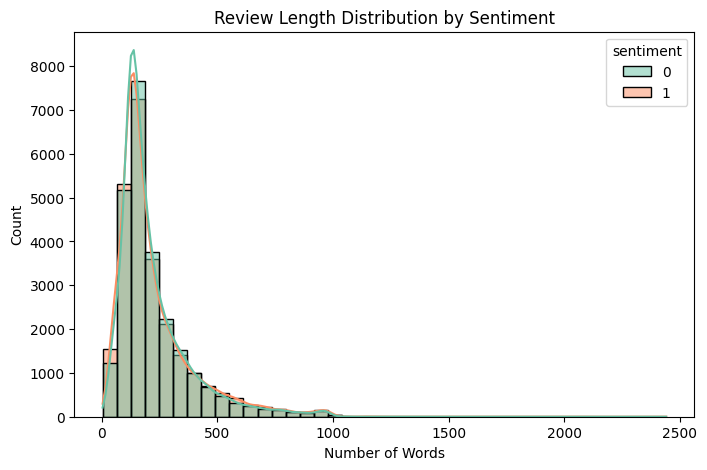

In [7]:

# Review Length Distribution
df["review_length"] = df["clean_review"].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="review_length", hue="sentiment", bins=40, kde=True, palette="Set2")
plt.title("Review Length Distribution by Sentiment")
plt.xlabel("Number of Words")
plt.show()

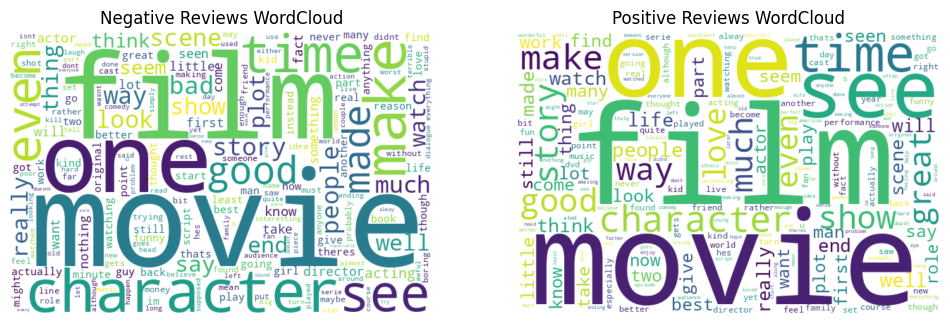

In [8]:


# Word Clouds
neg_text = " ".join(df[df["sentiment"]==0]["clean_review"].tolist())
pos_text = " ".join(df[df["sentiment"]==1]["clean_review"].tolist())
stopwords = set(STOPWORDS)

wc_neg = WordCloud(width=600, height=400, background_color="white", stopwords=stopwords).generate(neg_text)
wc_pos = WordCloud(width=600, height=400, background_color="white", stopwords=stopwords).generate(pos_text)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(wc_neg, interpolation="bilinear")
plt.title("Negative Reviews WordCloud")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wc_pos, interpolation="bilinear")
plt.title("Positive Reviews WordCloud")
plt.axis("off")
plt.show()

In [9]:

# Top N Words Function
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words="english").fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

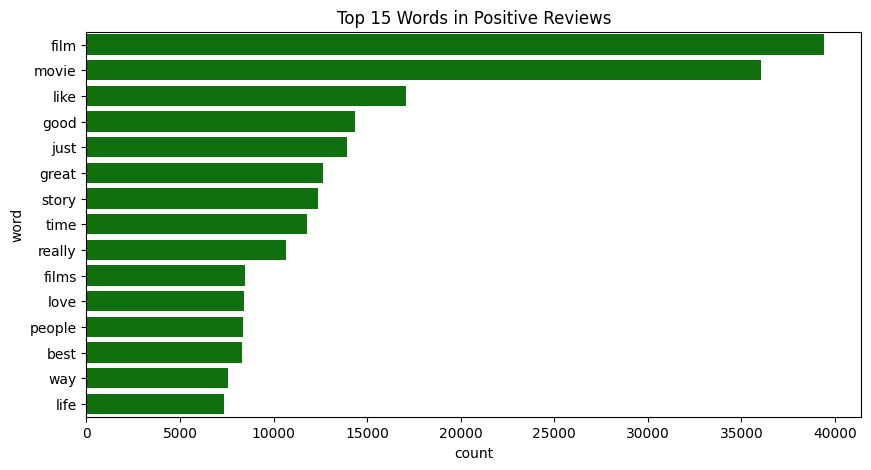

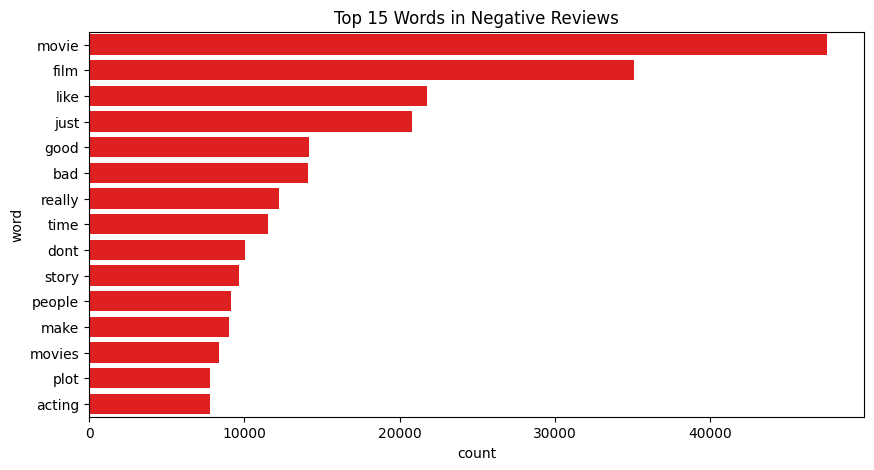

In [10]:
# Plot Top Words for Positive & Negative
top_pos = get_top_n_words(df[df["sentiment"]==1]["clean_review"], n=15)
top_neg = get_top_n_words(df[df["sentiment"]==0]["clean_review"], n=15)

top_pos_df = pd.DataFrame(top_pos, columns=["word","count"])
top_neg_df = pd.DataFrame(top_neg, columns=["word","count"])

plt.figure(figsize=(10,5))
sns.barplot(x="count", y="word", data=top_pos_df, color="green")
plt.title("Top 15 Words in Positive Reviews")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x="count", y="word", data=top_neg_df, color="red")
plt.title("Top 15 Words in Negative Reviews")
plt.show()

In [11]:
# Train-Test Split
X = df["clean_review"]
y = df["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Vectorize with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [15]:
# Train Naive Bayes Model
model = MultinomialNB()
model.fit(X_train_vec, y_train)

MultinomialNB()

In [16]:
# Predict on Test Data
y_pred = model.predict(X_test_vec)

In [17]:
# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%\n")

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Negative","Positive"]))

Accuracy: 84.77%

Classification Report:

              precision    recall  f1-score   support

    Negative       0.85      0.84      0.85      4961
    Positive       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



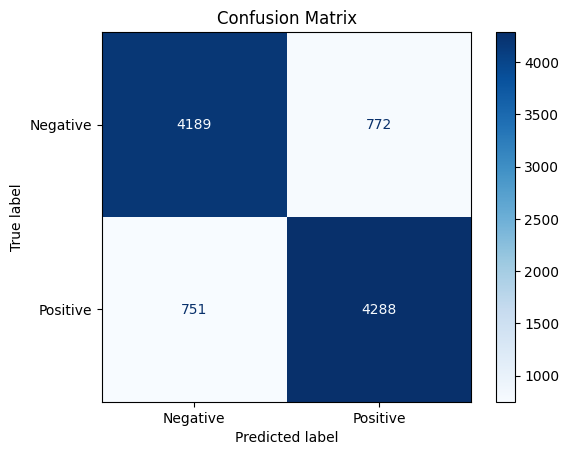

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative","Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [19]:
# 🔹 TEST NEW REVIEWS
# ============================================================
def predict_sentiment(text):
    text_clean = clean_text(text)
    text_vec = vectorizer.transform([text_clean])
    pred = model.predict(text_vec)[0]
    return "Positive" if pred==1 else "Negative"

In [20]:
# Example Predictions
examples = [
    "The movie was fantastic! I loved it.",
    "It was a terrible film, really boring and slow.",
    "Absolutely brilliant acting and story.",
    "Worst movie I have seen in years."
]

for review in examples:
    print(f"Review: {review}\nPredicted Sentiment: {predict_sentiment(review)}\n")

Review: The movie was fantastic! I loved it.
Predicted Sentiment: Positive

Review: It was a terrible film, really boring and slow.
Predicted Sentiment: Negative

Review: Absolutely brilliant acting and story.
Predicted Sentiment: Positive

Review: Worst movie I have seen in years.
Predicted Sentiment: Negative

